# Subsetting in space with lat/lon values

Updated: 2024-02-29, Leif Denby (lcd@dmi.dk)

Unfortunately, DANRA data is not on a lat/lon-coordinate aligned grid, but is instead stored on a rotated lat/lon grid. To subset the data in the horizontal domain we can instead construct a mask in the grid-aligned coordinates that are gauranteed to include a lat/lon extent.

Let's first start by plotting the whole domain again so we can see what we are working with:

In [1]:
from pathlib import Path

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

In [2]:
version = "v0.3.0"
# path to copies of processed DANRA datasets on scale.dmi.dk:
# fp_root = Path(f"/dmidata/projects/cloudphysics/danra/data/{version}")
# path on ohm.dmi.dk where the files where processed:
fp_root = Path(f"/nwp/danra/data/{version}")

In [3]:
ds_sl = xr.open_zarr(fp_root / "single_levels.zarr")
ds_sl

<xarray.Dataset>
Dimensions:          (time: 29120, y: 589, x: 789)
Coordinates:
    lat              (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    lon              (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
  * time             (time) datetime64[ns] 1990-09-01 ... 2000-08-18T21:00:00
  * x                (x) float64 -1.999e+06 -1.997e+06 ... -3.175e+04 -2.925e+04
  * y                (y) float64 -6.095e+05 -6.07e+05 ... 8.58e+05 8.605e+05
Data variables: (12/27)
    cape_column      (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    cb_column        (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    ct_column        (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    grpl_column      (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    hcc0m            (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    icei0m           (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    ...               ...
    t0m              (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    t2m              (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    u10m             (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    v10m             (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    vis0m            (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    xhail0m          (time, y, x) float64 dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
Attributes:
    description:  All prognostic variables for 10-year period on reduced levels

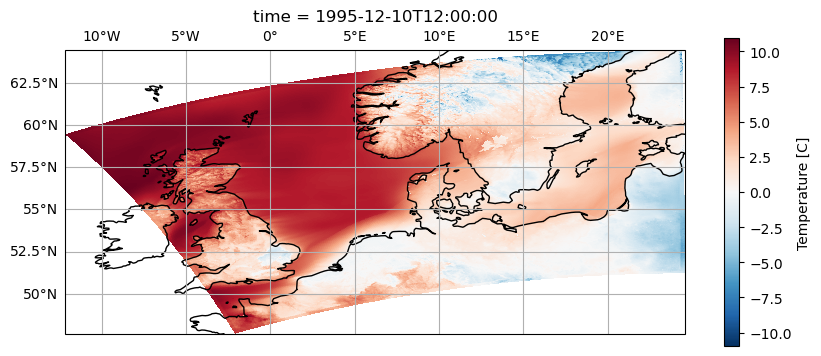

In [4]:
ds = ds_sl
# let's add a 2m temperature in celcius to work with
ds["t2m_celcius"] = ds.t2m - 273.15
ds.t2m_celcius.attrs["units"] = "C"
ds.t2m_celcius.attrs["long_name"] = ds.t2m.long_name
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds.t2m_celcius.sel(time="1995-12-10T12:00").plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=["top", "left"])
ax.coastlines()

Using the lat/lon extents of the bounding-box we'd like to work within we can then construct a mask:

In [5]:
bbox = [8, 16, 54, 58] # W, E, S, N
da_mask = np.logical_and(
    np.logical_and(ds.lon > bbox[0], ds.lon < bbox[1]),
    np.logical_and(ds.lat > bbox[2], ds.lat < bbox[3]),
)

Let's plot that mask to check it has the extent we're interested in:

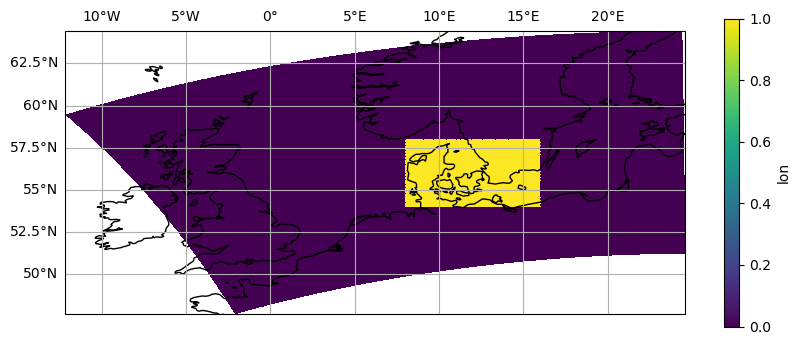

In [6]:
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
da_mask.plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=["top", "left"])
ax.coastlines()

And finally we can crop on that mask (by including `drop=True` in the selection with `.where(...)`):

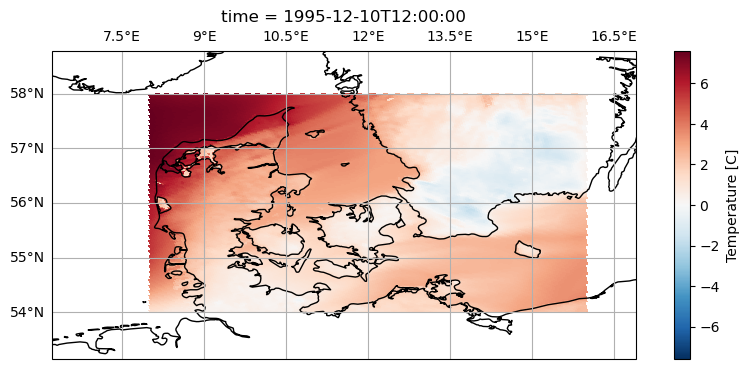

In [7]:
ds_cropped = ds.where(da_mask.compute(), drop=True)

fig, ax = plt.subplots(figsize=(10, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_cropped.t2m_celcius.sel(time="1995-12-10T12:00").plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=["top", "left"])
ax.coastlines()

We can also construct a grid-aligned crop which contains the original lat/lon bounding-box by using the min/max values in the original grid coordinates:

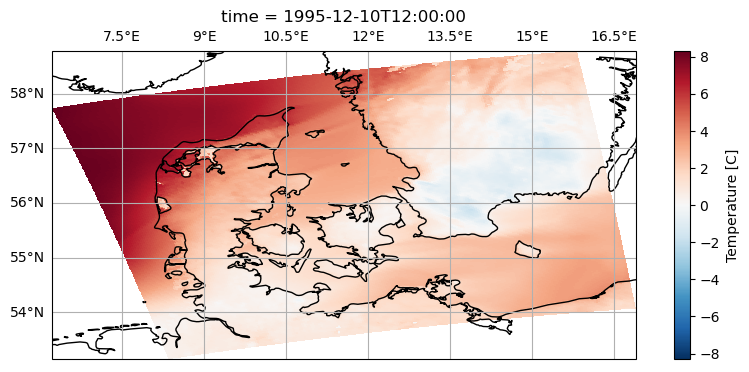

In [8]:
x_min, x_max = ds_cropped.x.min(), ds_cropped.x.max()
y_min, y_max = ds_cropped.y.min(), ds_cropped.y.max()

ds_cropped_xy = ds.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

fig, ax = plt.subplots(figsize=(10, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_cropped_xy.t2m_celcius.sel(time="1995-12-10T12:00").plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=["top", "left"])
ax.coastlines()